In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
import spacy
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

from bioinfokit.analys import get_data, stat
import scipy.stats as stats

import json
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')

from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/Shared drives/540-group-project

/content/drive/Shared drives/540-group-project


In [ ]:
yelp = pd.read_csv('yelp_review.csv')

In [ ]:
if 'Unnamed: 0' in yelp.columns:
  yelp = yelp.drop('Unnamed: 0', axis=1)
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641534 entries, 0 to 641533
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   business_id        641534 non-null  object
 1   categories         641534 non-null  object
 2   review_id          641534 non-null  object
 3   user_id            641534 non-null  object
 4   stars              641534 non-null  int64 
 5   useful             641534 non-null  int64 
 6   text               641534 non-null  object
 7   date               641534 non-null  object
 8   user_review_count  641534 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 44.1+ MB


In [ ]:
yelp.iloc[3]

business_id                                     2rQFgavS-942RapZTBSBTw
categories           Italian, Pizza, Restaurants, American (Traditi...
review_id                                       pWJZOVlRYQoDth22olrjjg
user_id                                         KQSRUu4Aapl0hG6eu2v8iw
stars                                                                1
useful                                                               1
text                 Edit: I don't know what happened. The service ...
date                                               2018-04-02 00:24:09
user_review_count                                                  759
Name: 3, dtype: object

EDA

In [ ]:
yelp.describe()

,stars,useful,user_review_count
count,641534.000000,641534.000000,641534.000000
mean,3.936473,2.671886,251.476399
std,1.254529,4.689409,506.754421
min,1.000000,1.000000,20.000000
25%,3.000000,1.000000,48.000000
50%,4.000000,1.000000,110.000000
75%,5.000000,3.000000,256.000000
max,5.000000,325.000000,17473.000000


In [ ]:
numerical_feats = yelp.dtypes[yelp.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))
categorical_feats = yelp.dtypes[yelp.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  3
Number of Categorical features:  6


In [ ]:
print(yelp[numerical_feats].columns)
print("*"*100)
print(yelp[categorical_feats].columns)

Index(['stars', 'useful', 'user_review_count'], dtype='object')
****************************************************************************************************
Index(['business_id', 'categories', 'review_id', 'user_id', 'text', 'date'], dtype='object')


Text(0.5, 1.0, 'Distribution of text length')

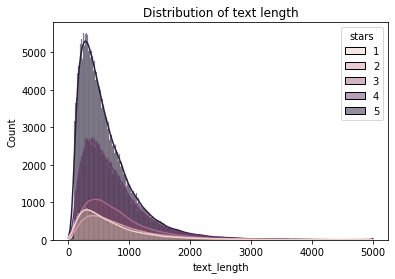

In [ ]:
temp_df = yelp.copy()
temp_df['text_length'] = temp_df['text'].apply(lambda x: len(x))
sns.histplot(data=temp_df, x='text_length', hue='stars', kde=True)
plt.title('Distribution of text length')

In [ ]:
yelp.max()

business_id                                     zznZqH9CiAznbkV6fXyHWA
categories           Yoga, Food, Active Life, Fitness & Instruction...
review_id                                       zzzlQD_iocCwpiCgz5mYRw
user_id                                         zzz-M4QvkEpUWWPL9RTzLA
stars                                                                5
useful                                                             325
text                 這是一家很有氣氛的餐廳  不會很吵鬧 \n很適合浪漫的情侶或溫馨的家庭朋友聚會\n我們點的每...
date                                               2021-12-31 23:49:24
user_review_count                                                17473
dtype: object

In [ ]:
temp_df_1 = yelp.copy()
temp_df_1['year'] = pd.DatetimeIndex(temp_df_1['date']).year
temp_df_1.head()
temp_df_1['month'] = pd.DatetimeIndex(temp_df_1['date']).month
temp_df_1.head()
temp_df_1['month_year'] = pd.to_datetime(temp_df_1['date']).dt.to_period('M')
temp_df_1.head()

,business_id,categories,review_id,user_id,stars,useful,text,date,user_review_count,year,month,month_year
0,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",MKNp_CdR2k2202-c8GN5Dw,3-1va0IQfK-9tUMzfHWfTA,5,5,I ordered a graduation cake for my niece and i...,2018-05-20 17:58:57,28,2018,5,2018-05
1,UQssxfQY7LcLEtagk9ecog,"Pakistani, Indian, Restaurants, Halal",0y3cVL5vdd9zpSDN-kaOIQ,3-1va0IQfK-9tUMzfHWfTA,5,1,I was pleasantly surprised when I dined here l...,2018-01-18 14:53:43,28,2018,1,2018-01
2,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",_hJu0u6nB-8LIeQJY4Vg4w,KQSRUu4Aapl0hG6eu2v8iw,4,1,This is my favorite bakery in Chinatown! I usu...,2018-03-17 23:47:25,759,2018,3,2018-03
3,2rQFgavS-942RapZTBSBTw,"Italian, Pizza, Restaurants, American (Traditi...",pWJZOVlRYQoDth22olrjjg,KQSRUu4Aapl0hG6eu2v8iw,1,1,Edit: I don't know what happened. The service ...,2018-04-02 00:24:09,759,2018,4,2018-04
4,UNWb37aMC3nuWdszceGMxg,"Restaurants, Pakistani, Indian",bTQSVdKqplptyJaynbBWJA,KQSRUu4Aapl0hG6eu2v8iw,3,2,I've ordered delivery and also ate in the rest...,2018-05-12 02:52:28,759,2018,5,2018-05


Text(0.5, 1.0, 'text length in different years')

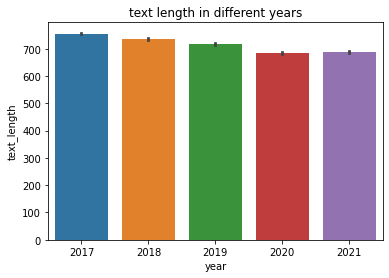

In [ ]:
#text length decrease according to the time
temp_df_1['text_length'] = temp_df_1['text'].apply(lambda x: len(x))
sns.barplot(data=temp_df_1, x='year', y= 'text_length')
plt.title('text length in different years')


Text(0.5, 1.0, 'useful condition according to time')

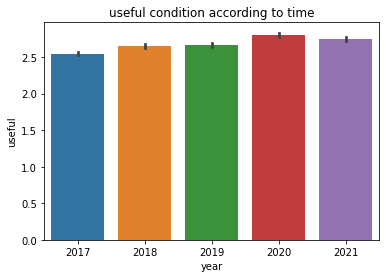

In [ ]:
sns.barplot(data=temp_df_1, x='year', y ='useful')
plt.title('useful condition according to time')

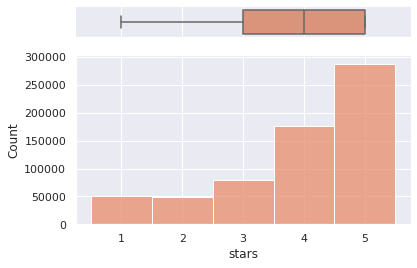

In [ ]:
sns.set(style="darkgrid")
sns.set_palette("flare")
 
# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# assigning a graph to each ax
sns.boxplot(data=yelp, x="stars", ax=ax_box)
sns.histplot(data=yelp, bins=np.arange(1, 7) - 0.5, x="stars", ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='', yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

In [ ]:
text = " ".join(review for review in yelp.text)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 462966372 words in the combination of all review.


In [ ]:
# about 30m
# Create stopword list:
stopwords = set(STOPWORDS)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Data Process and Tokenrize

In [ ]:
def preprocess_text(text, stem=False):
    text = text.lower()
    # delete special characters
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)
    # delete links
    text = re.sub(r'http\S+', '', text)
    # delete multispaces
    text = re.sub('\s\s+', ' ', text)
    # delete digits
    text = re.sub(r'[0-9]+', '', text)
    # delete stop words
    text = text.split(' ')
    text = ' '.join([word for word in text if not word in STOPWORDS])
    
    text = remove_stopwords(text)
    if stem:
        stem = SnowballStemmer(language='english')
        text = ' '.join([stem.stem(word) for word in text.split(' ')])
    else:
        lemmatizer = WordNetLemmatizer()
        text = ' '.join([lemmatizer.lemmatize(word) for word in text.split(' ')])
    text = text.strip()
    return text

In [ ]:
import os.path

if not os.path.isfile('yelp_review_nostop_punc_engOnly_lem.csv') :
    yelp = pd.read_csv('yelp_review.csv')
    if 'Unnamed: 0' in yelp.columns:
        yelp = yelp.drop('Unnamed: 0', axis=1)
    for i in tqdm(range(len(yelp))):
        yelp.loc[i,'text']  = preprocess_text(yelp.loc[i,'text'], stem=False)
    yelp.to_csv('yelp_review_nostop_punc_engOnly_lem.csv')

  0%|          | 436/641534 [00:20<8:20:08, 21.36it/s]


KeyboardInterrupt: ignored

In [ ]:
# 'yelp_review_nostop_punc_engOnly.csv' is using SnowballStemmer
# 'yelp_review_nostop_punc_engOnly_lem.csv' is using WordNetLemmatizer

yelp = pd.read_csv('yelp_review_nostop_punc_engOnly_lem.csv')

In [ ]:
import random
from random import sample

random.seed(5)

corpus = sample(yelp["text"].apply(str).to_list(), 300000)

In [ ]:
vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
    )
X_tfidf = vectorizer.fit_transform(corpus)
X_tfidf.shape
# 26s

(300000, 41456)

In [ ]:
print(f"We find that around {X_tfidf.nnz / np.prod(X_tfidf.shape) * 100:.3f}% of the entries of the X_tfidf matrix are non-zero.")

In [ ]:
from sklearn.cluster import KMeans

def fit_diff_n_clusters_and_evaluation(X_tfidf, n_clusters: list):
    evaluation = pd.DataFrame(columns=["n_clusters", "Davies-Bouldin Score", "Silhouette Coefficient"])
    for n_c in n_clusters:
        kmeans = KMeans(
            n_clusters=n_c,
            max_iter=100,
            n_init=5,
        )
        kmeans.set_params(random_state=42)
        kmeans.fit(X_tfidf)
        db_score = metrics.davies_bouldin_score(X_tfidf.toarray(), kmeans.labels_)
        silhouette_score = metrics.silhouette_score(X_tfidf.toarray(), kmeans.labels_, sample_size=2000)
        evaluation.loc[len(evaluation),] = [n_c, db_score, silhouette_score]
    return evaluation

In [ ]:
fit_diff_n_clusters_and_evaluation(X_tfidf, range(2, 21))

In [ ]:
kmeans = KMeans(
            n_clusters=10,
            max_iter=100,
            n_init=5,
        )
kmeans.set_params(random_state=42)
kmeans.fit(X_tfidf)

In [ ]:
clusters = kmeans.labels_

def get_top_keywords(X, vectorizer, clusters, n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(X_tfidf, vectorizer, clusters, 50)

take 1000 sample data to label them manually

In [ ]:
generate_sample = False
if generate_sample:
  yelp_o = pd.read_csv('yelp_review.csv')
  yelp_o = yelp_o[["review_id", "text"]]
  yelp_sample = yelp_o.sample(n=2000)

  features = ['breakfast/brunch',
  'atmosphere',
  'mexican food',
  'fast food',
  'waiting time',
  'service quality',
  'Japanese food/seafood',
  'pizza/wings',
  'healthy',
  'flavor',
  'bar/alcohol',
  'price',
  'location']
  for f in features:
      yelp_sample[f] = 0

  yelp_sample.to_csv('yelp_review_aspects_sample.csv')

## Classifier

### After labeling 1000 data points with 12 features, we picked 8 strong features and now using them to train different classification models on each of them.

In [ ]:
labeled_data = pd.read_csv('Label sheets - Sheet1.csv', index_col=0)[:1000]

# convert '`' to 1, I suppose
labeled_data.loc[392988, "pizza/wings"] = 1
# convert 'NaN' to 0, I suppose
labeled_data.loc[576915, "pizza/wings"] = 0

labeled_data.fillna(0)
labeled_data["atmosphere"] = pd.to_numeric(labeled_data["atmosphere"])
labeled_data["pizza/wings"] = pd.to_numeric(labeled_data["pizza/wings"])
labeled_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 48645 to 413303
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   review_id              1000 non-null   object 
 1   text                   1000 non-null   object 
 2   breakfast/brunch       1000 non-null   int64  
 3   atmosphere             999 non-null    float64
 4   mexican food           1000 non-null   int64  
 5   fast food              1000 non-null   int64  
 6   waiting time           1000 non-null   int64  
 7   service quality        1000 non-null   int64  
 8   Japanese food/seafood  1000 non-null   int64  
 9   pizza/wings            1000 non-null   int64  
 10  healthy                1000 non-null   int64  
 11  flavor                 1000 non-null   int64  
 12  bar/alcohol            1000 non-null   int64  
 13  price                  1000 non-null   int64  
 14  location               1000 non-null   int64  
dty

In [ ]:
labeled_data.fillna(0).astype(bool).sum(axis=0)

review_id                1000
text                     1000
breakfast/brunch           72
atmosphere                329
mexican food               75
fast food                 118
waiting time              174
service quality           528
Japanese food/seafood     125
pizza/wings                69
healthy                   131
flavor                    837
bar/alcohol               137
price                     197
location                  148
dtype: int64

In [ ]:
labeled_data.drop(columns=["breakfast/brunch", "mexican food", "fast food", "pizza/wings", "healthy"], inplace = True)
for i in tqdm(labeled_data.index.values.tolist()):
    labeled_data.loc[i,'text']  = preprocess_text(labeled_data.loc[i,'text'], stem=False)

KeyError: ignored

In [ ]:
label_corpus = labeled_data["text"].apply(str).to_list()

X_tfidf_label = vectorizer.transform(label_corpus)
X_tfidf_label.shape

(1000, 41456)

In [ ]:
y_atmosphere = np.array(labeled_data['atmosphere'])
y_waiting = np.array(labeled_data['waiting time'])
y_service = np.array(labeled_data['service quality'])
y_seafood = np.array(labeled_data['Japanese food/seafood'])
y_flavor = np.array(labeled_data['flavor'])                                                                
y_alcohol = np.array(labeled_data['bar/alcohol'])
y_price= np.array(labeled_data['price'])
y_location = np.array(labeled_data['location'])

In [ ]:
y_atmosphere = np.nan_to_num(y_atmosphere)

In [ ]:
y_list = [y_atmosphere, y_waiting, y_service, y_seafood, y_flavor, y_alcohol, y_price, y_location]

In [ ]:
def check(array_list):

    n = 1

    for array in array_list: 
        if min(array) != -1 or max(array) != 1 or True in np.isnan(array):
            return 'error: ' + str(n)
        n += 1

In [ ]:
check(y_list)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from xgboost.sklearn import XGBClassifier
from sklearn import tree
import sklearn

In [ ]:
def train_models(X_train,y_train,model='Decision_Tree'):
    if model == 'Decision_Tree':
        clf = tree.DecisionTreeClassifier()
        clf = clf.fit(X_train, y_train)
        return clf
    elif model == 'Gradient_Boosting':
        clf = GradientBoostingClassifier()
        clf.fit(X_train, y_train)
        return clf
    elif model == 'Logistic_Regression':
        clf = LogisticRegression()
        clf.fit(X_train, y_train)
        return clf      
    elif model == 'Random_Forest':
        clf = RandomForestClassifier(max_depth=10)
        clf.fit(X_train, y_train)
        return clf
    elif model == 'XGBoost':
        clf = XGBClassifier(max_depth=10)
        clf.fit(X_train, y_train)
        return clf

In [ ]:
def evaluate_model(X_test, y_test, model):

    y_predict = model.predict(X_test)

    accuracy = sklearn.metrics.accuracy_score(y_test, y_predict)
    f1 = sklearn.metrics.f1_score(y_test, y_predict, average = 'weighted')
    roc = sklearn.metrics.roc_auc_score(y_test, model.predict_proba(X_test), multi_class = 'ovr')

    return (accuracy, f1, roc)

In [ ]:
def classifier(X_train, y_train, X_test, y_test):

    model_name_list = ['Decision_Tree', 'Gradient_Boosting', 'Logistic_Regression', 'Random_Forest', 'XGBoost']

    accuracy_list = []
    f1_list = []
    roc_list = []
    model_list = []

    for model_name in model_name_list:

        model = train_models(X_train, y_train, model_name)
        metrics = evaluate_model(X_test, y_test, model)

        accuracy_list.append(metrics[0])
        f1_list.append(metrics[1])
        roc_list.append(metrics[2])
        model_list.append(model)
      
    model_comparison_atmosphere = pd.DataFrame({'Model Name': model_name_list, 'Accuracy' : accuracy_list, 'F1 Score': f1_list, 'ROC AUC' : roc_list,
                                                'Model': model_list})

    return model_comparison_atmosphere  

In [ ]:
yelp_all = pd.read_csv('yelp_review_nostop_punc_engOnly_lem.csv')

In [ ]:
yelp_all_corpus = yelp_all["text"].apply(str).to_list()

X_tfidf_all = vectorizer.transform(yelp_all_corpus)
X_tfidf_all.shape

(641534, 41456)

### Atmosphere

In [ ]:
X_train_atm, X_test_atm, y_train_atm, y_test_atm = train_test_split(
    X_tfidf_label, y_atmosphere, test_size=0.2, stratify=y_atmosphere, random_state = 0)

In [ ]:
atm_classifier_df = classifier(X_train_atm, y_train_atm, X_test_atm, y_test_atm)

In [ ]:
atm_classifier_df

,Model Name,Accuracy,F1 Score,ROC AUC,Model
0,Decision_Tree,0.655,0.653735,0.607349,DecisionTreeClassifier(random_state=0)
1,Gradient_Boosting,0.720,0.689520,0.754583,([DecisionTreeRegressor(criterion='friedman_ms...
2,Logistic_Regression,0.690,0.588354,0.765453,LogisticRegression(random_state=0)
3,Random_Forest,0.670,0.537605,0.717395,"(DecisionTreeClassifier(max_depth=10, max_feat..."
4,XGBoost,0.735,0.701168,0.805440,"XGBClassifier(max_depth=10, objective='multi:s..."


In [ ]:
def f1_score_test(X_train, y_train, X_test, y_test):

    f1_list_0 = []
    f1_list_1 = []
    f1_list_2 = []
    f1_list_3 = []
    f1_list_4 = []

    for i in range(0,10):

        df = classifier(X_train, y_train, X_test, y_test)

        f1_list_0.append(df['F1 Score'][0])
        f1_list_1.append(df['F1 Score'][1])
        f1_list_2.append(df['F1 Score'][2])
        f1_list_3.append(df['F1 Score'][3])
        f1_list_4.append(df['F1 Score'][4])
    
    f1_df_atm = pd.DataFrame({'Decision_Tree': f1_list_0,
                   'Gradient_Boosting': f1_list_1,
                  'Logistic_Regression': f1_list_2,
                   'Random_Forest': f1_list_3,
                   'XGBoost':f1_list_4})
    
    return f1_df_atm

In [ ]:
f1_df_atm = f1_score_test(X_train_atm, y_train_atm, X_test_atm, y_test_atm)

In [ ]:
f1_df_atm

,Decision_Tree,Gradient_Boosting,Logistic_Regression,Random_Forest,XGBoost
0,0.655925,0.689520,0.588354,0.537605,0.701168
1,0.667803,0.692790,0.588354,0.537605,0.701168
2,0.673142,0.691753,0.588354,0.537605,0.701168
3,0.674753,0.686186,0.588354,0.537605,0.701168
4,0.673720,0.691251,0.588354,0.537605,0.701168
5,0.673720,0.700057,0.588354,0.537605,0.701168
6,0.666987,0.713000,0.588354,0.537605,0.701168
7,0.666987,0.679066,0.588354,0.537605,0.701168
8,0.657327,0.698268,0.588354,0.537605,0.701168
9,0.700888,0.692238,0.588354,0.537605,0.701168


In [ ]:
# ANOVA
fvalue, pvalue = stats.f_oneway(f1_df_atm['Decision_Tree'], f1_df_atm['Gradient_Boosting'], f1_df_atm['Logistic_Regression'],
                                f1_df_atm['Random_Forest'], f1_df_atm['XGBoost'])
print(fvalue, pvalue)

1100.0825387710422 3.0639320417885315e-44


In [ ]:
# t-test
stats.ttest_ind(f1_df_atm['Gradient_Boosting'], f1_df_atm['XGBoost'])

Ttest_indResult(statistic=-2.186042692024804, pvalue=0.04226667258211638)

Select XGBoost as the classifier for atmosphere

In [ ]:
atm_classifier = atm_classifier_df['Model'][4]

In [ ]:
y_atm_all = atm_classifier.predict(X_tfidf_all)

### Waiting Time

In [ ]:
X_train_waiting, X_test_waiting, y_train_waiting, y_test_waiting = train_test_split(
    X_tfidf_label, y_waiting, test_size=0.2, stratify=y_waiting)

In [ ]:
waiting_classifier_df = classifier(X_train_waiting, y_train_waiting, X_test_waiting, y_test_waiting)

In [ ]:
waiting_classifier_df

,Model Name,Accuracy,F1 Score,ROC AUC,Model
0,Decision_Tree,0.800,0.788119,0.627838,DecisionTreeClassifier()
1,Gradient_Boosting,0.840,0.810663,0.810741,([DecisionTreeRegressor(criterion='friedman_ms...
2,Logistic_Regression,0.830,0.757413,0.778644,LogisticRegression()
3,Random_Forest,0.825,0.745890,0.709251,"(DecisionTreeClassifier(max_depth=10, max_feat..."
4,XGBoost,0.840,0.807116,0.811128,"XGBClassifier(max_depth=10, objective='multi:s..."


In [ ]:
f1_df_waiting = f1_score_test(X_train_waiting, y_train_waiting, X_test_waiting, y_test_waiting)

In [ ]:
f1_df_waiting

,Decision_Tree,Gradient_Boosting,Logistic_Regression,Random_Forest,XGBoost
0,0.787118,0.781390,0.74589,0.74589,0.828894
1,0.777129,0.791558,0.74589,0.74589,0.828894
2,0.778902,0.784809,0.74589,0.74589,0.828894
3,0.781634,0.790343,0.74589,0.74589,0.828894
4,0.785214,0.786974,0.74589,0.74589,0.828894
5,0.780366,0.786910,0.74589,0.74589,0.828894
6,0.750206,0.790343,0.74589,0.74589,0.828894
7,0.796663,0.796309,0.74589,0.74589,0.828894
8,0.788463,0.783657,0.74589,0.74589,0.828894
9,0.765206,0.790343,0.74589,0.74589,0.828894


In [ ]:
# ANOVA
fvalue, pvalue = stats.f_oneway(f1_df_waiting['Decision_Tree'], f1_df_waiting['Gradient_Boosting'], f1_df_waiting['Logistic_Regression'],
                                f1_df_waiting['Random_Forest'], f1_df_waiting['XGBoost'])
print(fvalue, pvalue)

313.01192324789974 3.252140354024188e-32


In [ ]:
# t-test
stats.ttest_ind(f1_df_waiting['Gradient_Boosting'], f1_df_waiting['XGBoost'])

Ttest_indResult(statistic=-29.352571031295682, pvalue=1.1784630460422795e-16)

Select XGBoost as the classifier for waiting time

In [ ]:
waiting_classifier = waiting_classifier_df['Model'][4]

y_waiting_all = waiting_classifier.predict(X_tfidf_all)

### Service Quality

In [ ]:
X_train_service, X_test_service, y_train_service, y_test_service = train_test_split(
    X_tfidf_label, y_service, test_size=0.2, stratify=y_service)

In [ ]:
service_classifier_df = classifier(X_train_service, y_train_service, X_test_service, y_test_service)

In [ ]:
service_classifier_df

,Model Name,Accuracy,F1 Score,ROC AUC,Model
0,Decision_Tree,0.660,0.653211,0.684323,DecisionTreeClassifier()
1,Gradient_Boosting,0.735,0.716387,0.842903,([DecisionTreeRegressor(criterion='friedman_ms...
2,Logistic_Regression,0.585,0.538320,0.810322,LogisticRegression()
3,Random_Forest,0.550,0.460939,0.816144,"(DecisionTreeClassifier(max_depth=10, max_feat..."
4,XGBoost,0.755,0.744393,0.839883,"XGBClassifier(max_depth=10, objective='multi:s..."


In [ ]:
f1_df_service = f1_score_test(X_train_service, y_train_service, X_test_service, y_test_service)

In [ ]:
f1_df_service

,Decision_Tree,Gradient_Boosting,Logistic_Regression,Random_Forest,XGBoost
0,0.649324,0.730841,0.53832,0.492924,0.744393
1,0.645348,0.717645,0.53832,0.449498,0.744393
2,0.644102,0.713160,0.53832,0.449498,0.744393
3,0.658373,0.729926,0.53832,0.449392,0.744393
4,0.645314,0.729926,0.53832,0.475040,0.744393
5,0.677004,0.717975,0.53832,0.460939,0.744393
6,0.656667,0.722463,0.53832,0.408140,0.744393
7,0.641211,0.726202,0.53832,0.485926,0.744393
8,0.657410,0.717302,0.53832,0.401681,0.744393
9,0.657445,0.722463,0.53832,0.485447,0.744393


In [ ]:
# ANOVA
fvalue, pvalue = stats.f_oneway(f1_df_service['Decision_Tree'], f1_df_service['Gradient_Boosting'], f1_df_service['Logistic_Regression'],
                                f1_df_service['Random_Forest'], f1_df_service['XGBoost'])
print(fvalue, pvalue)

667.0967782717739 2.0294739933281695e-39


In [ ]:
# t-test
stats.ttest_ind(f1_df_service['Gradient_Boosting'], f1_df_service['XGBoost'])

Ttest_indResult(statistic=-10.938521700353038, pvalue=2.2076175318527103e-09)

Select XGBoost as the classifier for service quality

In [ ]:
service_classifier = service_classifier_df['Model'][4]

y_service_all = service_classifier.predict(X_tfidf_all)

### Seafood

In [ ]:
X_train_seafood, X_test_seafood, y_train_seafood, y_test_seafood = train_test_split(
    X_tfidf_label, y_seafood, test_size=0.2, stratify=y_seafood)

In [ ]:
seafood_classifier_df = classifier(X_train_seafood, y_train_seafood, X_test_seafood, y_test_seafood)

In [ ]:
seafood_classifier_df

,Model Name,Accuracy,F1 Score,ROC AUC,Model
0,Decision_Tree,0.870,0.859874,0.594458,DecisionTreeClassifier()
1,Gradient_Boosting,0.865,0.847890,0.867868,([DecisionTreeRegressor(criterion='friedman_ms...
2,Logistic_Regression,0.880,0.828434,0.841687,LogisticRegression()
3,Random_Forest,0.875,0.816667,0.758318,"(DecisionTreeClassifier(max_depth=10, max_feat..."
4,XGBoost,0.880,0.861711,0.891031,"XGBClassifier(max_depth=10, objective='multi:s..."


In [ ]:
f1_df_seafood = f1_score_test(X_train_seafood, y_train_seafood, X_test_seafood, y_test_seafood)

In [ ]:
f1_df_seafood

,Decision_Tree,Gradient_Boosting,Logistic_Regression,Random_Forest,XGBoost
0,0.876127,0.834028,0.828434,0.816667,0.861711
1,0.858966,0.850145,0.828434,0.816667,0.861711
2,0.833346,0.836654,0.828434,0.816667,0.861711
3,0.836925,0.839265,0.828434,0.816667,0.861711
4,0.854966,0.837566,0.828434,0.816667,0.861711
5,0.845204,0.845278,0.828434,0.816667,0.861711
6,0.858632,0.847890,0.828434,0.816667,0.861711
7,0.847331,0.841144,0.828434,0.816667,0.861711
8,0.841514,0.851583,0.828434,0.816667,0.861711
9,0.850162,0.844242,0.828434,0.816667,0.861711


In [ ]:
# ANOVA
fvalue, pvalue = stats.f_oneway(f1_df_seafood['Decision_Tree'], f1_df_seafood['Gradient_Boosting'], f1_df_seafood['Logistic_Regression'],
                                f1_df_seafood['Random_Forest'], f1_df_seafood['XGBoost'])
print(fvalue, pvalue)

81.97927170072438 4.5056093744831064e-20


In [ ]:
# t-test
stats.ttest_ind(f1_df_seafood['Decision_Tree'], f1_df_seafood['XGBoost'])

Ttest_indResult(statistic=-2.876911312992355, pvalue=0.010033025719047264)

Select XGBoost as the classifier for seafood

In [ ]:
seafood_classifier = seafood_classifier_df['Model'][4]

y_seafood_all = seafood_classifier.predict(X_tfidf_all)

### Flavor

In [ ]:
X_train_flavor, X_test_flavor, y_train_flavor, y_test_flavor = train_test_split(
    X_tfidf_label, y_flavor, test_size=0.2, stratify=y_flavor)

In [ ]:
flavor_classifier_df = classifier(X_train_flavor, y_train_flavor, X_test_flavor, y_test_flavor)

In [ ]:
flavor_classifier_df

,Model Name,Accuracy,F1 Score,ROC AUC,Model
0,Decision_Tree,0.660,0.643863,0.588557,DecisionTreeClassifier()
1,Gradient_Boosting,0.715,0.630070,0.678702,([DecisionTreeRegressor(criterion='friedman_ms...
2,Logistic_Regression,0.705,0.584735,0.782562,LogisticRegression()
3,Random_Forest,0.705,0.583021,0.702930,"(DecisionTreeClassifier(max_depth=10, max_feat..."
4,XGBoost,0.710,0.653476,0.769538,"XGBClassifier(max_depth=10, objective='multi:s..."


In [ ]:
f1_df_flavor = f1_score_test(X_train_flavor, y_train_flavor, X_test_flavor, y_test_flavor)

In [ ]:
f1_df_flavor

,Decision_Tree,Gradient_Boosting,Logistic_Regression,Random_Forest,XGBoost
0,0.609426,0.627342,0.584735,0.583021,0.653476
1,0.650154,0.629391,0.584735,0.583021,0.653476
2,0.649404,0.628910,0.584735,0.583021,0.653476
3,0.608947,0.637038,0.584735,0.583021,0.653476
4,0.640857,0.633452,0.584735,0.583021,0.653476
5,0.636323,0.638583,0.584735,0.583021,0.653476
6,0.649935,0.623907,0.584735,0.583021,0.653476
7,0.659896,0.627342,0.584735,0.583021,0.653476
8,0.619324,0.637738,0.584735,0.583021,0.653476
9,0.632419,0.634343,0.584735,0.583021,0.653476


In [ ]:
# ANOVA
fvalue, pvalue = stats.f_oneway(f1_df_flavor['Decision_Tree'], f1_df_flavor['Gradient_Boosting'], f1_df_flavor['Logistic_Regression'],
                                f1_df_flavor['Random_Forest'], f1_df_flavor['XGBoost'])
print(fvalue, pvalue)

147.00187133659963 3.206538230174926e-25


In [ ]:
# t-test
stats.ttest_ind(f1_df_flavor['Decision_Tree'], f1_df_flavor['XGBoost'])

Ttest_indResult(statistic=-3.138909902237104, pvalue=0.005674649198688418)

Select XGBoost as the classifier for flavor

In [ ]:
flavor_classifier = flavor_classifier_df['Model'][4]

y_flavor_all = flavor_classifier.predict(X_tfidf_all)

### Alcohol

In [ ]:
X_train_alcohol, X_test_alcohol, y_train_alcohol, y_test_alcohol = train_test_split(
    X_tfidf_label, y_alcohol, test_size=0.2, stratify=y_alcohol)

In [ ]:
alcohol_classifier_df = classifier(X_train_alcohol, y_train_alcohol, X_test_alcohol, y_test_alcohol)

In [ ]:
alcohol_classifier_df

,Model Name,Accuracy,F1 Score,ROC AUC,Model
0,Decision_Tree,0.840,0.832789,0.588735,DecisionTreeClassifier()
1,Gradient_Boosting,0.875,0.853386,0.858190,([DecisionTreeRegressor(criterion='friedman_ms...
2,Logistic_Regression,0.865,0.802386,0.805560,LogisticRegression()
3,Random_Forest,0.865,0.802386,0.768780,"(DecisionTreeClassifier(max_depth=10, max_feat..."
4,XGBoost,0.870,0.848580,0.757283,"XGBClassifier(max_depth=10, objective='multi:s..."


In [ ]:
f1_df_alcohol = f1_score_test(X_train_alcohol, y_train_alcohol, X_test_alcohol, y_test_alcohol)

In [ ]:
f1_df_alcohol

,Decision_Tree,Gradient_Boosting,Logistic_Regression,Random_Forest,XGBoost
0,0.825489,0.853386,0.802386,0.802386,0.84858
1,0.827738,0.842192,0.802386,0.802386,0.84858
2,0.800612,0.841652,0.802386,0.802386,0.84858
3,0.818269,0.844540,0.802386,0.802386,0.84858
4,0.830084,0.838587,0.802386,0.802386,0.84858
5,0.822638,0.852746,0.802386,0.802386,0.84858
6,0.819068,0.857186,0.802386,0.802386,0.84858
7,0.810167,0.849319,0.802386,0.802386,0.84858
8,0.829393,0.853050,0.802386,0.802386,0.84858
9,0.807767,0.839418,0.802386,0.802386,0.84858


In [ ]:
# ANOVA
fvalue, pvalue = stats.f_oneway(f1_df_alcohol['Decision_Tree'], f1_df_alcohol['Gradient_Boosting'], f1_df_alcohol['Logistic_Regression'],
                                f1_df_alcohol['Random_Forest'], f1_df_alcohol['XGBoost'])
print(fvalue, pvalue)

180.36419986724593 4.387836343384239e-27


In [ ]:
# t-test
stats.ttest_ind(f1_df_alcohol['Gradient_Boosting'], f1_df_alcohol['XGBoost'])

Ttest_indResult(statistic=-0.6470181775611092, pvalue=0.5257860766251303)

Result of Gradient Boosting and XGBoost are close. Select Gradient Boosting as the classifier for alcohol. 

In [ ]:
alcohol_classifier = alcohol_classifier_df['Model'][1]

y_alcohol_all = alcohol_classifier.predict(X_tfidf_all)

### Price

In [ ]:
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(
    X_tfidf_label, y_price, test_size=0.2, stratify=y_price)

In [ ]:
price_classifier_df = classifier(X_train_price, y_train_price, X_test_price, y_test_price)

In [ ]:
price_classifier_df

,Model Name,Accuracy,F1 Score,ROC AUC,Model
0,Decision_Tree,0.710,0.705322,0.551305,DecisionTreeClassifier()
1,Gradient_Boosting,0.745,0.714286,0.602460,([DecisionTreeRegressor(criterion='friedman_ms...
2,Logistic_Regression,0.800,0.711111,0.630993,LogisticRegression()
3,Random_Forest,0.800,0.711111,0.686942,"(DecisionTreeClassifier(max_depth=10, max_feat..."
4,XGBoost,0.760,0.718580,0.647842,"XGBClassifier(max_depth=10, objective='multi:s..."


In [ ]:
f1_df_price = f1_score_test(X_train_price, y_train_price, X_test_price, y_test_price)

In [ ]:
f1_df_price

,Decision_Tree,Gradient_Boosting,Logistic_Regression,Random_Forest,XGBoost
0,0.699712,0.710712,0.711111,0.711111,0.71858
1,0.685949,0.708571,0.711111,0.711111,0.71858
2,0.707319,0.716999,0.711111,0.711111,0.71858
3,0.722801,0.715034,0.711111,0.711111,0.71858
4,0.704194,0.711842,0.711111,0.711111,0.71858
5,0.695553,0.716999,0.711111,0.711111,0.71858
6,0.688718,0.713621,0.711111,0.711111,0.71858
7,0.708019,0.727461,0.711111,0.711111,0.71858
8,0.674740,0.709805,0.711111,0.711111,0.71858
9,0.703850,0.704391,0.711111,0.711111,0.71858


In [ ]:
# ANOVA
fvalue, pvalue = stats.f_oneway(f1_df_price['Decision_Tree'], f1_df_price['Gradient_Boosting'], f1_df_price['Logistic_Regression'],
                                f1_df_price['Random_Forest'], f1_df_price['XGBoost'])
print(fvalue, pvalue)

11.567752781775699 1.5256228604607092e-06


In [ ]:
# t-test
stats.ttest_ind(f1_df_price['Gradient_Boosting'], f1_df_price['XGBoost'])

Ttest_indResult(statistic=-2.542310751488831, pvalue=0.020425371290146342)

Select XGBoost as the classifier for price

In [ ]:
price_classifier = price_classifier_df['Model'][4]

y_price_all = price_classifier.predict(X_tfidf_all)

### Location

In [ ]:
X_train_location, X_test_location, y_train_location, y_test_location = train_test_split(
    X_tfidf_label, y_location, test_size=0.2, stratify=y_location)

In [ ]:
location_classifier_df = classifier(X_train_location, y_train_location, X_test_location, y_test_location)

In [ ]:
location_classifier_df

,Model Name,Accuracy,F1 Score,ROC AUC,Model
0,Decision_Tree,0.805,0.779657,0.522875,DecisionTreeClassifier()
1,Gradient_Boosting,0.845,0.780707,0.662050,([DecisionTreeRegressor(criterion='friedman_ms...
2,Logistic_Regression,0.850,0.781081,0.633030,LogisticRegression()
3,Random_Forest,0.850,0.781081,0.634989,"(DecisionTreeClassifier(max_depth=10, max_feat..."
4,XGBoost,0.845,0.788949,0.698684,"XGBClassifier(max_depth=10, objective='multi:s..."


In [ ]:
f1_df_location = f1_score_test(X_train_location, y_train_location, X_test_location, y_test_location)

In [ ]:
f1_df_location

,Decision_Tree,Gradient_Boosting,Logistic_Regression,Random_Forest,XGBoost
0,0.794312,0.783198,0.781081,0.781081,0.788949
1,0.779657,0.794585,0.781081,0.781081,0.788949
2,0.784962,0.783198,0.781081,0.781081,0.788949
3,0.767189,0.794585,0.781081,0.781081,0.788949
4,0.782790,0.794585,0.781081,0.781081,0.788949
5,0.771790,0.794585,0.781081,0.781081,0.788949
6,0.761335,0.783198,0.781081,0.781081,0.788949
7,0.777237,0.794585,0.781081,0.781081,0.788949
8,0.765314,0.783198,0.781081,0.781081,0.788949
9,0.783655,0.805323,0.781081,0.781081,0.788949


In [ ]:
# ANOVA
fvalue, pvalue = stats.f_oneway(f1_df_location['Decision_Tree'], f1_df_location['Gradient_Boosting'], f1_df_location['Logistic_Regression'],
                                f1_df_location['Random_Forest'], f1_df_location['XGBoost'])
print(fvalue, pvalue)

10.998347833290861 2.6322867652146106e-06


In [ ]:
# t-test
stats.ttest_ind(f1_df_location['Gradient_Boosting'], f1_df_location['XGBoost'])

Ttest_indResult(statistic=0.9030291554475464, pvalue=0.3784368439664888)

Results of Gradient Boosting and XGBoost are close. Select Gradient Boosting as the classifier for location

In [ ]:
location_classifier = location_classifier_df['Model'][1]

y_location_all = location_classifier.predict(X_tfidf_all)

### Aspect Dataframe

In [ ]:
aspect_df = pd.DataFrame({'Atmosphere': y_atm_all, 'Waiting_Time': y_waiting_all, 'Service_Quality': y_service_all, 'Seafood': y_seafood_all,
                          'Flavor': y_flavor_all, 'Alcohol': y_alcohol_all, 'Price': y_price_all, 'Location': y_location_all, 'Star': yelp_all['stars']})

In [ ]:
aspect_df['Atmosphere'] = aspect_df['Atmosphere'].astype(int)

In [ ]:
aspect_df

,Atmosphere,Waiting_Time,Service_Quality,Seafood,Flavor,Alcohol,Price,Location,Star
0,0,0,1,0,1,0,0,0,5
1,0,0,1,0,1,0,0,0,5
2,1,0,1,0,1,0,1,0,4
3,0,-1,1,0,1,0,0,0,1
4,0,1,1,0,1,0,0,0,3
...,...,...,...,...,...,...,...,...,...
641529,0,0,-1,0,1,0,0,0,3
641530,0,0,1,0,1,0,0,0,5
641531,0,0,-1,0,0,0,0,0,1
641532,0,-1,1,0,1,0,0,0,5


In [ ]:
aspect_df.to_csv('aspect_df.csv')